# Russian salary statistics

Импортируем необходимые библиотеки:

In [98]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [99]:
%matplotlib inline

In [100]:
salary = pd.read_csv('./WAG_C_M.csv', sep=',', index_col=['month'], parse_dates=['month'], dayfirst=True)
salary.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295 entries, 1993-01-01 to 2017-07-01
Data columns (total 1 columns):
WAG_C_M    295 non-null float64
dtypes: float64(1)
memory usage: 4.6 KB


In [101]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [102]:
salary.describe()

,WAG_C_M
count,295.000000
mean,13189.022034
std,12827.576682
min,15.300000
25%,1404.000000
50%,8093.000000
75%,23533.000000
max,47554.000000


In [103]:
salary.rename(columns={'WAG_C_M': 'salary_rub'}, inplace=True)

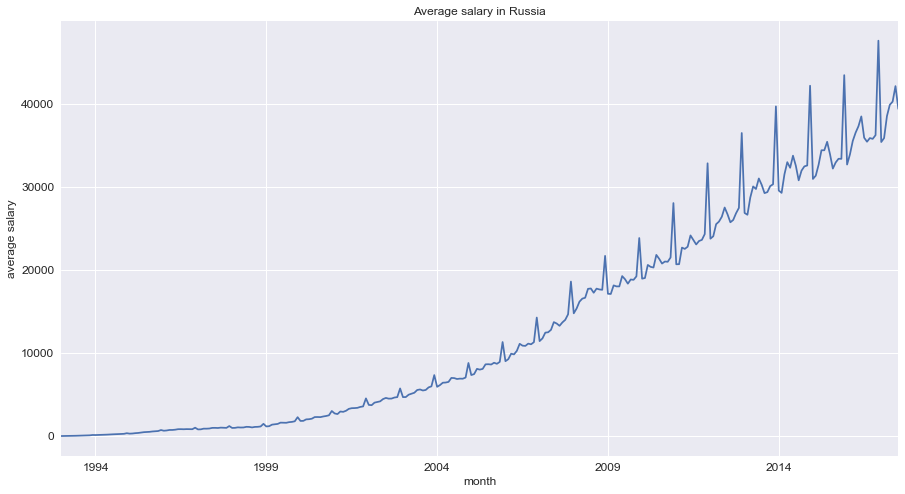

In [104]:
salary.salary_rub.plot(figsize=(15, 8), title='Average salary in Russia', fontsize=12);
plt.xlabel('month', fontsize=12)
plt.ylabel('average salary', fontsize=12)
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.997449


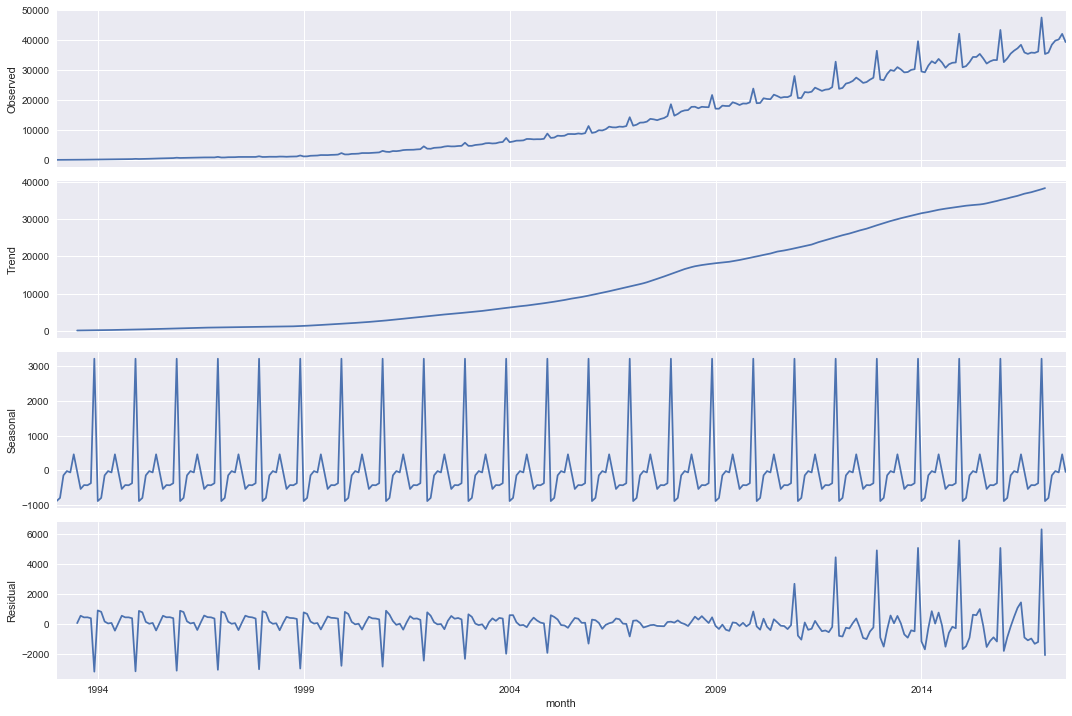

In [105]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_rub).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_rub)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.270826
Критерий Дики-Фуллера: p=0.755371


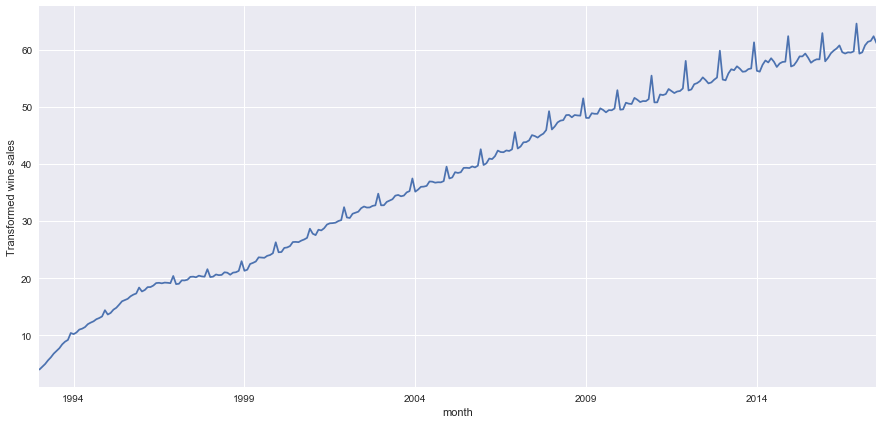

In [106]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary_rub)
plt.figure(figsize(15,7))
salary.salary_box.plot()
plt.ylabel('Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, что логично, ведь есть тренд и сезонность.  
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.007547


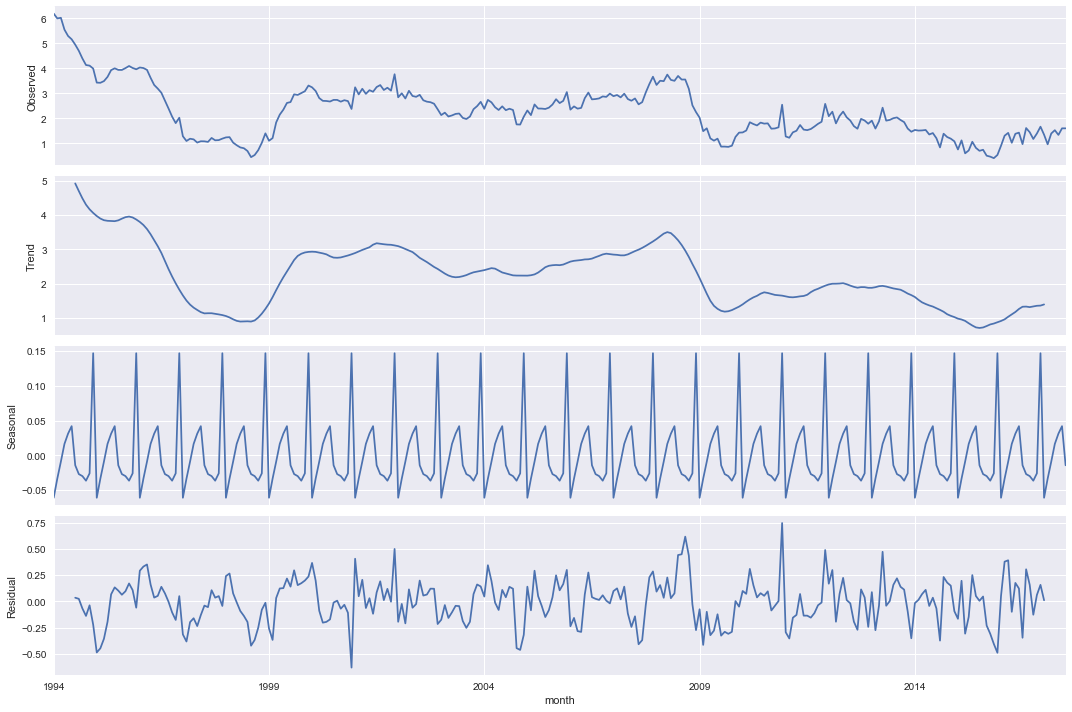

In [107]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

Критерий Дики-Фуллера уже отверг гипотезу о нестационарности, причём довольно уверенно, однако попробуем всё же ещё и обыное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


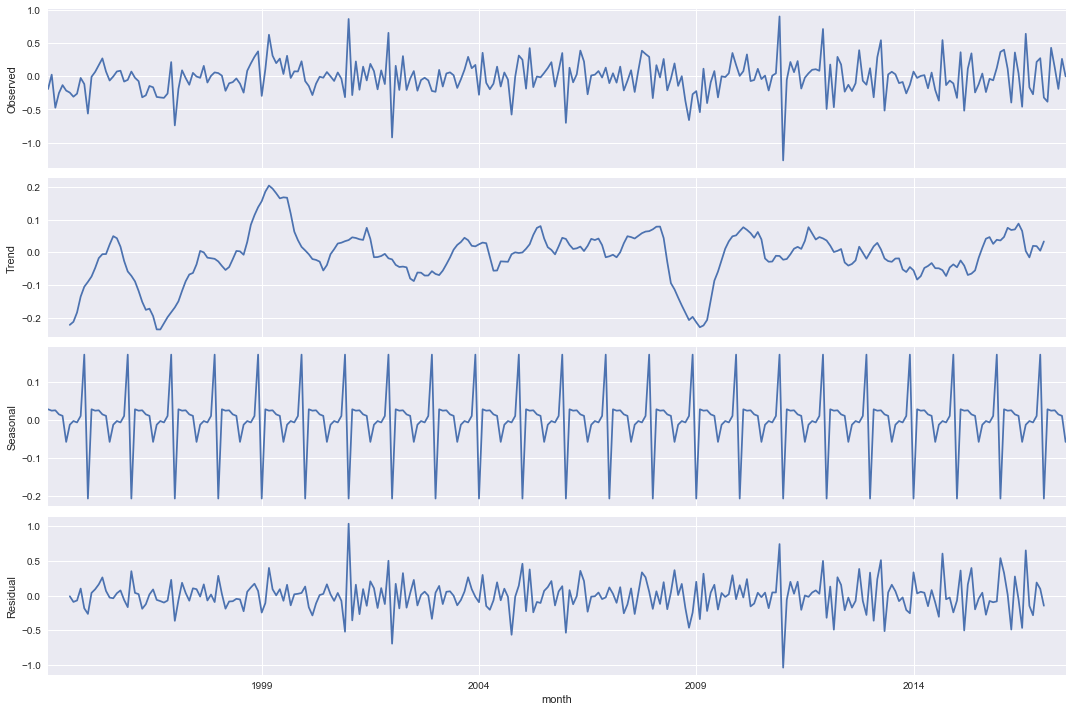

In [108]:
salary['salary_box_diff12_1'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(salary.salary_box_diff12_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff12_1[13:])[1])

Стало намного лучше. Теперь будем использовать столбец salary_diff как временной ряд для настройки моделей.

In [109]:
salary.salary_box_diff = salary.salary_box_diff12_1
salary.drop('salary_box_diff12_1', axis=1, inplace=True)

## Подбор модели

Посмотрим на ACF и PACF полученного ряда

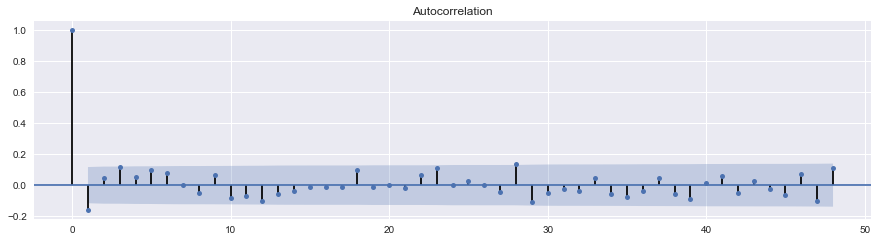

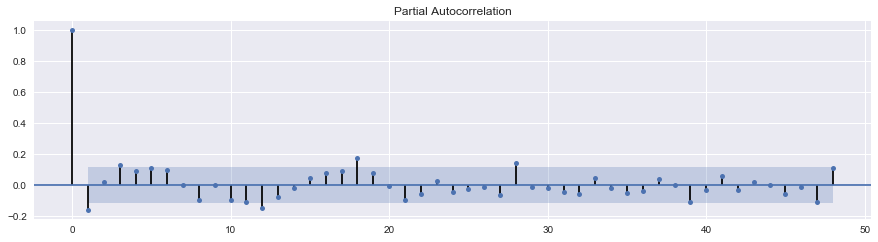

In [110]:
plt.figure(figsize(15,8))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 18

In [111]:
ps = range(0, 19)
d = 1
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

In [112]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

76

In [113]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
Wall time: 1min 47s


In [114]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
42  (11, 0, 1, 0)  32.439359
44  (11, 1, 1, 0)  33.024574
46  (12, 0, 1, 0)  33.176255
22   (6, 0, 1, 0)  33.938163
69  (18, 0, 0, 0)  33.960830


Лучшая модель:

In [115]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          salary_box   No. Observations:                  295
Model:             SARIMAX(11, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  -3.220
Date:                             Fri, 15 Sep 2017   AIC                             32.439
Time:                                     00:26:50   BIC                             80.370
Sample:                                 01-01-1993   HQIC                            51.632
                                      - 07-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2609      0.045     -5.784      0.000      -0.349      -0.173
ar.L2         -0.0338      

Посмотрим на остатки модели:

Критерий Стьюдента: p=0.240076
Критерий Дики-Фуллера: p=0.000000


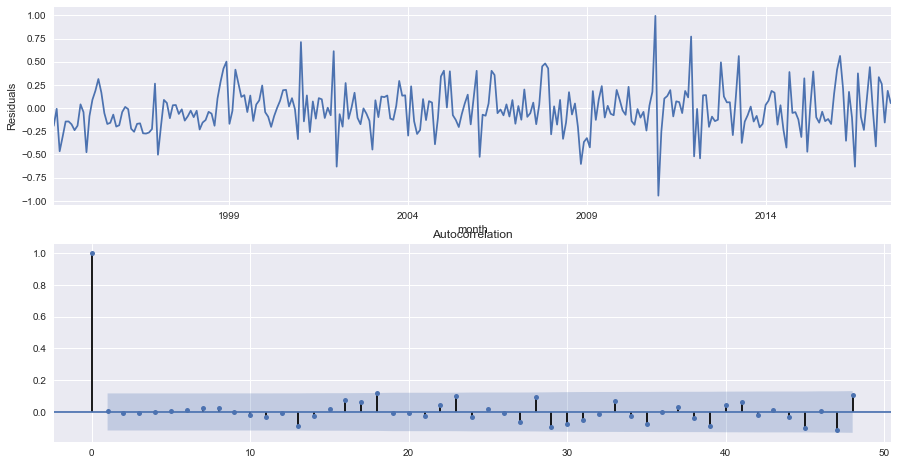

In [116]:
plt.figure(figsize(15,8))

plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

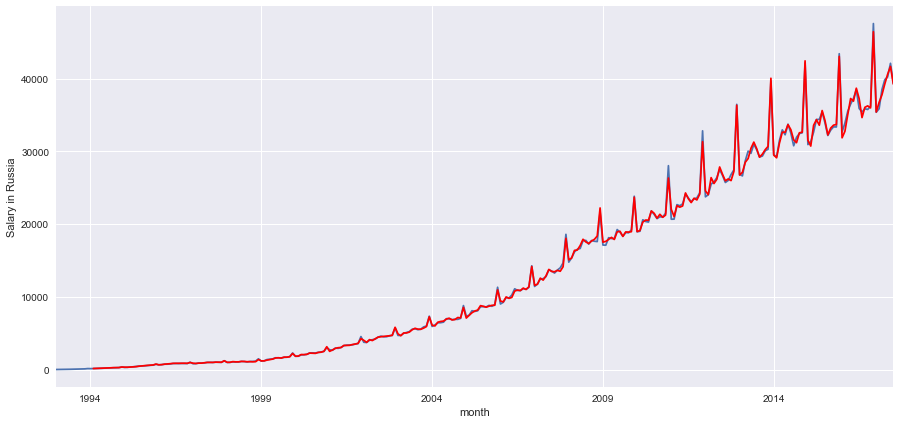

In [117]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize(15,7))

salary.salary_rub.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary in Russia')
pylab.show()

### Прогноз

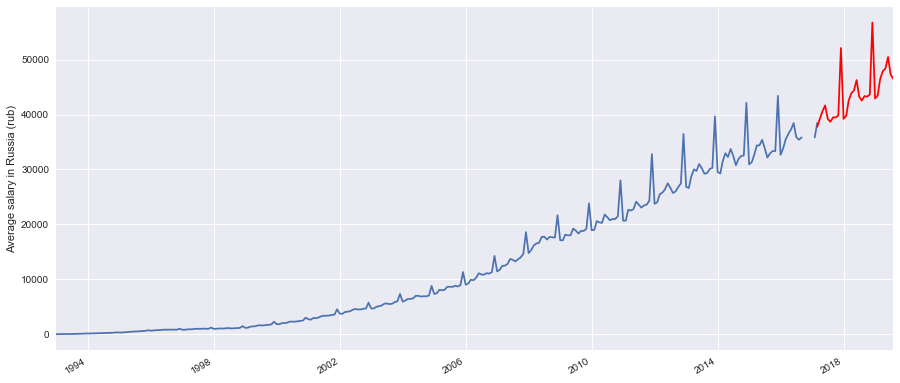

In [118]:
salary2 = salary[['salary_rub']]

date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)

salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=290, end=325), lmbda)

plt.figure(figsize(15,7))
salary2.salary_rub.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Average salary in Russia (rub)')
pylab.show()